# Lesson 1 Notebook
In this notebook we will work with documents as vectors in a high dimensional space. We will look at some different ways of doing this using well established methods.

## Running this file on Google Colab
In this workshop we will be using Google Colab. To open this notebook in colab use the following URL: [Lesson 1 Notebook](https://colab.research.google.com/github/ENCCS/contemporary-nlp/blob/main/content/notebooks/lesson_1.ipynb)

You need to save a local copy of this notebook to your own Google Drive if you want the changes to be saved.

In [ ]:
import zipfile
from pathlib import Path

## The data

In this notebook we will be working with comparing documents. We will work with real world data in the form of *patent applications*. These are documents which are submitted to patent organizations (in our case the European Patent Office, EPO) when requesting a patent. 

Published patent applications are open, so is a good source of example data for natural language processing.

The documents used in this workshop are downloaded from the EPO [European Publication Server web service](https://www.epo.org/searching-for-patents/data/web-services/publication-server.html). In particular, the patent applications are available as XML documents with clear structure. Below is an example of how these might look and the corresponding PDF version (which we will not be using).

![title](images/patent_application_pdf_xml.png)

We've prepared data for the workshop by extracting relevant fields from the XML documents and saved them as json-formatted documents. 

**N.b.** in a patent, each paragraph is numbered which can be used to cross reference between parts of the document. While this is essential to e.g. understand the claims, the methods we will use in this workshop can not make use of it, and therefore we haven't included them in the processed text.

### Downloading the data
We supply an archive of the data which we will now download

In [ ]:
import urllib

In [ ]:
data_url = "https://cdn.thingiverse.com/assets/d0/b3/68/63/1e/Gate_Guide_Spacer_v9.stl"
data_root = Path('data')
data_path = data_root / 'sampled_archive.zip'
data_root.mkdir(exist_ok=True)

In [ ]:
urllib.request.urlretrieve(data_url, data_path)

In [ ]:
# This extracts the documents in the document root
with zipfile.ZipFile(data_path) as zf:
    zf.extractall(data_root)

Now let's have a look at how these files are structured. The archive contained two subdirectories, each having documents belonging to a specific class. Throughout this workshop we will be working with these two classes. When using NLP for semantic search, we are often tasked with searching some large set of documents for a specific subset. We will call the subset we're searching for the "relevant" set.

Our task is to achive as good *precision* and *recall* as possible on this relevant set.

In [ ]:
import json
document_directories = [d for d in data_root.iterdir() if d.is_dir()]
document_classes = [d.name for d in document_directories]
print(document_classes)

The data is organized in text files containing JSON data, where each file is a single patent application. When parsed in python, the documents are organized as dictionaries.

Let's have a look at the keys they contain:

In [ ]:
document_sample_path = next(document_directories[0].iterdir())
with open(document_sample_path) as fp:
    document_sample = json.load(fp)
print(document_sample.keys())

Here's a description of the different keys:
  - `abstract`: The text from the abstract of the document. This is often a succint text actually describing the contents of the patent.
  - `description`: This is the main body of text of the document, containing all materials which support the claims being made.
  - `claims`: This is a structured descriptions of the claims the patent seek. In other words, this is the description of what should be protected and is what the patent office should decide on.
  - `document_number`: This is the number assigned to an application when published.
  - `ipc_classes`: This is a list of IPC codes which has been assigned to the patent. The IPC system is a way of "tagging" the contributions of a patent so that it can be searched for in the future.
  - `language`: The language the application is publshied in. In this workshop we're only working with english patent applications.
  - `publication_date`: The date the application was published.

In this workshop, we'll mainly focus on the `abstract`, `claims` and `description`, since these are the parts containing natural language. Each of these keys in turn index a dictionary like below:

In [ ]:
document_sample['abstract'].keys()

Let's have a look at the contents. Claims and description can be long so we only look at the first 1000 characters.

In [ ]:
document_sample['abstract']['en']

In [ ]:
document_sample['claims']['en'][:1000]

In [ ]:
document_sample['description']['en'][:1000]

In [ ]:
text_corpus = 

### Corpus

We'll be implementing a class to easily iterate over the documents 

In [ ]:
from collections.abc import Sequence
from collections import defaultdict

class PatentCorpus:
    def __init__(self, *, document_root: Path, document_parts=('abstract', 'description', 'claims'), lang='en'):
        self.document_root = document_root
        self.document_parts = document_parts
        self.lang = lang

        self.documents  = sorted(self.document_root.glob('**/*.json'))
        self.labeled_documents = defaultdict(list)
        for document in self.documents:
            label = str(document.parent)
            self.labeled_documents[label].append(document)
    
    def __len__(self):
        return len(self.documents)

    def load_document(self, document_path):
        with open(document_path) as fp:
            document = json.load(fp)
            document_str = '\n'.join([document[part][self.lang] for part in self.document_parts])
            return document_str

    def __getitem__(self, item):
        # Lazily load documents here
        if isinstance(item, slice):
            document_paths = self.documents[item]
            document_str = [self.load_document(document_path) for document_path in document_paths]
        elif isinstance(item, Sequence):
            document_str = [self.load_document(self.documents[idx]) for idx in item]
        else:
            document_str = self.load_document(self.documents[item])
        return document_str

In [298]:
from collections.abc import Sequence
from collections import defaultdict
import json

class ZipPatentCorpus:
    def __init__(self, *, document_archive: Path, document_parts=('abstract', 'description', 'claims'), lang='en'):
        self.document_archive = document_archive
        self.document_zf = zipfile.ZipFile(self.document_archive)
        self.document_parts = document_parts
        self.lang = lang

        self.documents  = sorted(filename for filename in self.document_zf.namelist())
        self.symbolic_labels = []
        self.labeled_documents = defaultdict(list)
        for document in self.documents:
            label, sep, file = document.rpartition('/')
            self.symbolic_labels.append(label)
            self.labeled_documents[label].append(document)
        self.label_codes = {label: i for i, label in enumerate(sorted(self.labeled_documents.keys()))}
        self.labels = [self.label_codes[label] for label in self.symbolic_labels]
    
    def __len__(self):
        return len(self.documents)

    def load_document(self, document_path):
        with self.document_zf.open(document_path) as fp:
            document = json.load(fp)
            document_str = '\n'.join([document[part][self.lang] for part in self.document_parts])
            return document_str

    def __getitem__(self, item):
        # Lazily load documents here
        if isinstance(item, slice):
            document_paths = self.documents[item]
            document_str = [self.load_document(document_path) for document_path in document_paths]
        elif isinstance(item, Sequence):
            document_str = [self.load_document(self.documents[idx]) for idx in item]
        else:
            document_str = self.load_document(self.documents[item])
        return document_str
    
    def get_label(self, i):
        return self.labels[i]
    
    def get_symbolic_label(self, i):
        return self.symbolic_labels[i]

In [508]:
text_corpus = ZipPatentCorpus(document_archive=data_path, document_parts=['abstract'])

In [ ]:
text_corpus = PatentCorpus(document_root=data_root)

In [507]:
text_corpus

## Bag-of-Words

We'll start by using one of the simplest representations of these documents: the bag-of-words representation. In these, each document  is represented by a vector $\mathbf{d}_i$ of term presence variables $t_{i,j}$:

$$ \mathbf{d}_i = \begin{bmatrix}t_{i,1}& \dots & t_{i,n}\end{bmatrix} $$

The $t_{i,j}$ is the variable which expresses to what degree the term $j$ is present in the document. This variable can be a binary, where the prescence of the word is indicated or it can be a frequency of how often the word occurs in the document. In the latter case, the sum of all these frequencys are typically normalized so that they add up to $1$.

### Tokenization
To be able to construct this bag-of-words reprsentation, we need to decide on what terms are actually valid. We need to take this string of characters and divide it into *tokens*, a process referred to as *tokenization*. 

Tokenization is a difficult topic, because we need to make hard decisions which might destroy information. In english, it has been common to base tokenization on white space, since words in english are typically separated in this manner. Furthermore, some characters like `,` and `(` are mostly syntactic and the methods we'll look at today will not make use of this. We will therefore strip away a lot of these kinds of characters. We will also convert any upper case letter to lower case.

We start with looking at a simple way of doing this, and later progress to use prebuilt preprocessing steps with better fidelity.




In [301]:
import re

# We define the characters we would like to have in a word. 
# The pattern below says that a word is any sequence of characters 
# in the set of A-Z, a-z, 0-9 and the special characters "-", "+", "=" "'" and ".". 
# How to tokenize depends on the domain. For novels we wouldn't include the special characters, 
# but in this patent data it's often used in technical terms, e.g. in names for chemicals which we 
# would like to include as distinct terms like "2.2'-dihydroxy-4-methoxybenzophenone"
# The inclusion of the period "." means whe have to treat this separately when it's 
# surrounded by word-characters compared to when it's used to end a sentence.
# While this could be done using a regex, it would complicate the pattern. Instead we 
# take care of that using the pyhton `str.strip()` method
# Terms consisting only of numbers are often not useful for us, and could indeed introduce 
# spurious similarities. Two documents contraining the number "0.005" is probably not a good 
# indication that they are semantically similar. The way we handle this in the below pattern 
# is that we require our words to contain at least one letter

# Catches multiple (or none) of any of the characters we allow
general_pattern = r"[A-Za-z0-9\-\+='.]*" 
# Only matches letter
letters = r"[A-Za-z]"  
# Matches a string which is a sequence of our general pattern, but contains at least one letter
word_pattern = re.compile(f"{general_pattern}{letters}{general_pattern}")

def tokenize_text(text):
    # Lowercase each document and match to our regular expression, strip any trailing periods
    tokens = [word.strip('.') for word in re.findall(word_pattern, text.lower())]
    return tokens

In [302]:
example_text = """UV filters are suitably used in the compositions of the present invention. 
Suitable UV-absorbing substances is are: 4-Aminobenzoic acid and the esters and salts thereof, 
2-phenyl benzimidazole-5-sulfonic acid and the alkali and amine salts thereof, 4-dimethyl aminobenzoic 
acid and the esters and salts thereof, cinnamic acid and the esters and salts thereof, 4-methoxycinnamic 
acid and the esters and salts thereof, salicylic acid and the esters and salts thereof, 
2.4-dihydroxybenzophenone, 2.2'.4.4'-tetrahydroxybenzophenone, 2-hydroxy-4-methoxybenzophenone 
and its 5-sulfonic acid or the sodium salt thereof, 2.2'-dihydroxy-4.4'-dimethoxybenzophenone, 
2-hydroxy-5-chlorobenzophenone, 2.2'-dihydroxy-4-methoxybenzophenone, 
2.2'-dihydroxy-4.4'-dimethoxy-5.5'-disulfobenzo-phenone or the sodium salt thereof, 
2-hydroxy-4-octyloxybenzophenone, 2-hydroxy-4-methoxy-4'-methylbenzophenone, 3-benzyl-idenecampher, 
3-(4'-sulfo)-benzyl-idenebornane-2-one and the salts thereof, 3-(4'-methyl benzylidene)-DL-campher, 
and/or polysilicone-15. The amount of the UV-absorber ranges typically from about 0.01 % to 2.5%, 
more preferably from 0.05 % to 1 % by weight, calculated to the total composition."""

print(tokenize_text(example_text))

['uv', 'filters', 'are', 'suitably', 'used', 'in', 'the', 'compositions', 'of', 'the', 'present', 'invention', 'suitable', 'uv-absorbing', 'substances', 'is', 'are', '4-aminobenzoic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', '2-phenyl', 'benzimidazole-5-sulfonic', 'acid', 'and', 'the', 'alkali', 'and', 'amine', 'salts', 'thereof', '4-dimethyl', 'aminobenzoic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', 'cinnamic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', '4-methoxycinnamic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', 'salicylic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', '2.4-dihydroxybenzophenone', "2.2'.4.4'-tetrahydroxybenzophenone", '2-hydroxy-4-methoxybenzophenone', 'and', 'its', '5-sulfonic', 'acid', 'or', 'the', 'sodium', 'salt', 'thereof', "2.2'-dihydroxy-4.4'-dimethoxybenzophenone", '2-hydroxy-5-chlorobenzophenone', "2.2'-dihydroxy-4-methoxybenzophenone", "2.2'-dihydroxy-4.4'-dimethoxy-5.5'-di

In [519]:
from collections import Counter

tokenized_documents = [tokenize_text(document) for document in text_corpus]

# Count word frequencies

documents_term_frequencies = [Counter(term for term in document) for document in tokenized_documents]
total_term_frequency = Counter()
for document_term_frequency in documents_term_frequencies:
    total_term_frequency.update(document_term_frequency)

### The probability distribution of words

A fundamental challange with dealing with words, is that some are much more common than others. We would like the terms we use in our simple bag-of-words model to contain as much semantics about the document as possible, i.e. what *the document is actually about*. Many words play a more syntactic role, they glue the more semantically meaningful. Examples of these are `a`, `the`, `and`, `to`. In reality, they do convey semantics, e.g. `the white house` and `white house` have different meaning, but to handle this the model would have to be able to learn things about combination of terms, which our bag-of-words model cannot.

Let's have a look at the terms we have picked out and how common they are. We will concentrate on the most frequent terms.

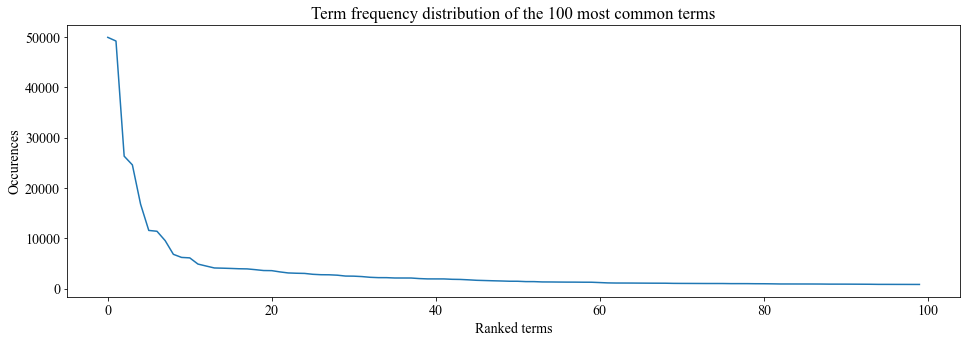

In [520]:
import matplotlib.pyplot as plt
import numpy as np

k = 100
words, counts = zip(*total_term_frequency.most_common(k))

plt.figure(figsize=(16,5))
plt.plot(np.arange(len(counts)), counts)
plt.xlabel("Ranked terms")
plt.ylabel("Occurences")
plt.title(f"Term frequency distribution of the {k} most common terms"); # The semi-colon just defers printing the last output here

### Zipf's law

As you can see in the above example, our term frequency distribution is heavily skewed towards the most common terms, while we have a tail of infrequent words which diminishes slowly. One way to think about this is that certain words are extremely common, while most words are used very rarely. In particular, words with very distinct semantics are rare in our corpus. This property of language was observered early on in linguistics, but the american George Kingley Zipf was the one who popularized it, which is the reason for why it's often referred to as Zipf's law.

*Why is this a problem?*

The reason is that we  will use methods which compare documents based on these frequencies, and the terms which dominates can drown out similarities between more semantically meaningful words.

As an example, let's have a look at the 50 most common words

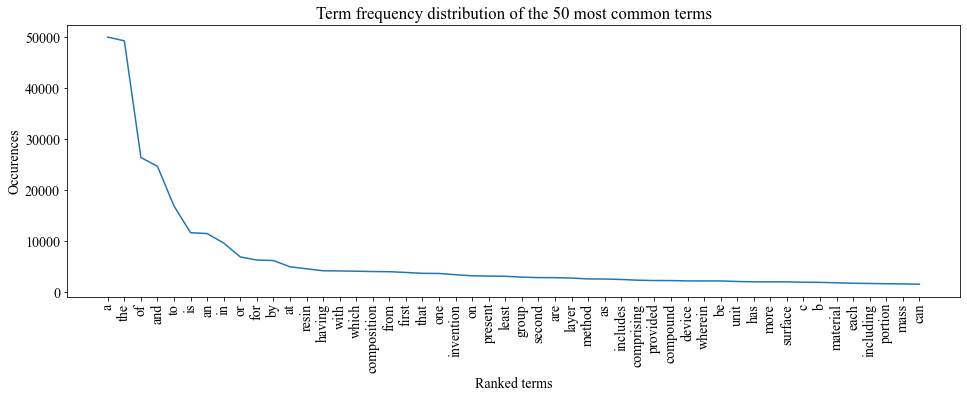

In [521]:
k = 50
words, counts = zip(*total_term_frequency.most_common(k))
x = np.arange(len(counts))
plt.figure(figsize=(16,5))
plt.plot(x, counts)
plt.xlabel("Ranked terms")
plt.ylabel("Occurences")
plt.title(f"Term frequency distribution of the {k} most common terms")
plt.xticks(x, words, rotation=90); # The semi-colon just defers printing the last output here

As you can see, even quite common words like `it` is far less common than words like `the`, `a` and `of`.

Let's zoom in and look at how this distribution look a bit further away from the top ranks

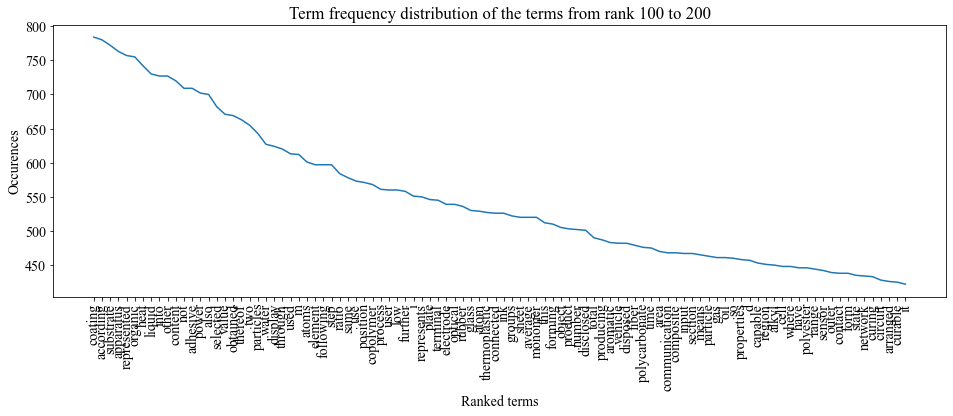

In [522]:
start_rank = 100
end_rank = 200
words, counts = zip(*list(total_term_frequency.most_common(end_rank))[start_rank:])
x = np.arange(len(counts))
plt.figure(figsize=(16,5))
plt.plot(x, counts)
plt.xlabel("Ranked terms")
plt.ylabel("Occurences")
plt.title(f"Term frequency distribution of the terms from rank {start_rank} to {end_rank}")
plt.xticks(x, words, rotation=90); # The semi-colon just defers printing the last output here

You can see that we start seing more words which would be useful to actually tell the contents of documents apart, such as `copolymer` or `pressure`.

Based on these statistics, we can make a **decision** about removing some words which we think will hurt our similiarity measure. We often refer to these words as *stop words*, beacuse they are words in a *stop list* which will be stopped from occuring in our documents.

In our case, we will just remove the words which are very dominant in the corpus

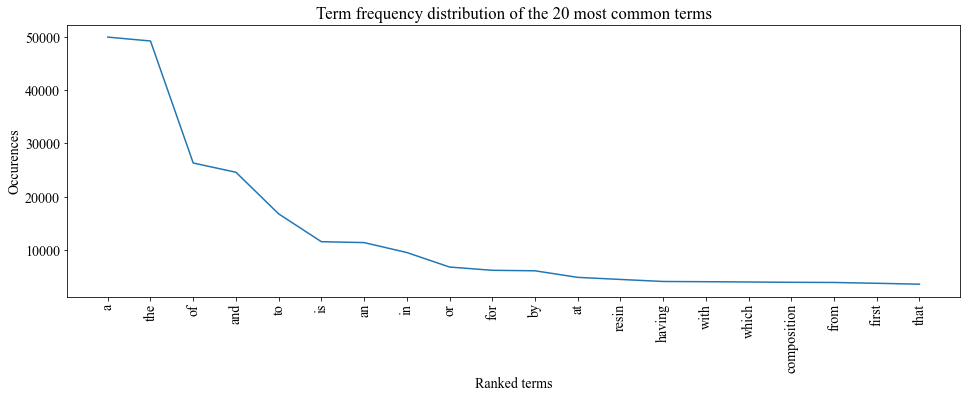

In [523]:
k = 20
words, counts = zip(*total_term_frequency.most_common(k))
x = np.arange(len(counts))
plt.figure(figsize=(16,5))
plt.plot(x, counts)
plt.xlabel("Ranked terms")
plt.ylabel("Occurences")
plt.title(f"Term frequency distribution of the {k} most common terms")
plt.xticks(x, words, rotation=90); # The semi-colon just defers printing the last output here

In [308]:
stoplist = set(['the', 'of', 'a', 'and', 'to', 'in', 'is', 'or', 'an', 'by', 'as', 'be', 'for'])

### Infrequent words

Apart from very common words hurting performance, there are many words which occur in only a single document. Common sources for this is misspellings or very niche words. While these words might be truly meaningful, if they occur in only one document we can't use them to find other documents which are similiar.

We therefore remove these infrequent words as well. While it's a given to drop those which only occur once, we might also wish to drop other infrequent words since they will not give us much in terms of statistical power.

In [524]:
def get_infrequent_terms(documents_term_frequencies, total_term_frequency, threshold):
    document_occurance_counts = Counter()
    for document_term_frequency in documents_term_frequencies:
        document_occurance_counts.update(document_term_frequency.keys()) # And a count once for each unique term in a document
    infrequent_by_document = set(term for term, count in document_occurance_counts.items() if count < threshold)
    infrequent_list_by_term = set(term for term, count in total_term_frequency.items() if count < threshold)
    return infrequent_by_document, infrequent_list_by_term

In [525]:
infrequent_by_document, infrequent_list_by_term = get_infrequent_terms(documents_term_frequencies, total_term_frequency, 2)

In [526]:
len(infrequent_list_by_term)

7791

In [527]:
len(total_term_frequency)

20531

In [529]:
frequency_by_document_by_threshold = []
frequency_by_term_by_threshold = []
for i in range(2, 5):
    infrequent_by_document, infrequent_by_term = get_infrequent_terms(documents_term_frequencies, total_term_frequency, i)
    frequency_by_document_by_threshold.append((i, len(infrequent_by_document)))
    frequency_by_term_by_threshold.append((i, len(infrequent_by_term)))

In [530]:
frequency_by_document_by_threshold

[(2, 10806), (3, 13423), (4, 14706)]

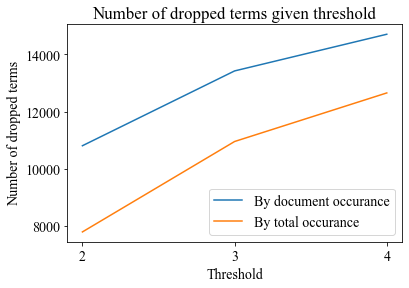

In [531]:
x1, y1 = zip(*frequency_by_document_by_threshold)
x2, y2 = zip(*frequency_by_term_by_threshold)

plt.plot(x1, y1, label="By document occurance")
plt.plot(x2, y2, label="By total occurance")
plt.xlabel("Threshold")
plt.ylabel("Number of dropped terms")
plt.title("Number of dropped terms given threshold")
plt.xticks(x1)
plt.legend();

In [532]:
drop_list = stoplist | set(term for term, count in total_term_frequency.items() if count < 2)
drop_list
# Only keep words that appear more than once
#processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]

{'non-resonantly',
 'thermo-isolating',
 'computerized',
 'controllers',
 '3-hydroxyhexanoate',
 'solb3',
 'spurs',
 '15u',
 '114r',
 '65wt',
 'parting',
 'diglyceride',
 'durations',
 'fes',
 'liners',
 'segregate',
 'downol',
 '50mol',
 'pmax',
 'wristwatch',
 'spurt',
 'guideline',
 'consider',
 'non-halogenated',
 'regulatory',
 'aminotriazine',
 'chr1x0-d-sizo2',
 'n-doped',
 'feedforward',
 '5t+50',
 'lifted',
 'filter-deaerator',
 '1h-pyrazolo',
 'banking',
 'repelling-free',
 'tdag8',
 'overview',
 'bump-provided',
 'triphenyl',
 'glycidoxy',
 'digestion',
 'neuroscience',
 'impinges',
 'helicopters',
 'diaper',
 'communication-based',
 'pbat',
 'antifolates',
 'massively',
 'extendable',
 'whichever',
 'crimp',
 '218a',
 'a',
 'hydrolysis-condensate',
 'processings',
 'public-key',
 'debrief',
 'm16',
 'titanyl',
 'diol-component',
 'porta',
 'lb-4',
 'throwing',
 'limitations',
 'multi-dimensional',
 'dla',
 'weakly',
 'luminances',
 'absorbable',
 'anodization',
 'saliva',
 

### *Choosing* a vocabulary

What terms we choose to include in our vocabulary will affect the performance of our methods. We would like to include as many meaningful terms as possible, but there is a trade-off to make here. The larger we make our vocabulary, the more computationally costly will our methods be. Furthermore, a large vocabulary will essentially lead to a underdetermined system, so we might run into issues of identifiability (essentially that there are an infinite number of equally good solutions).

This leads us to having to limit our vocabulary. We often do this in a data driven fashion, using word frequencies as we've discussed above or deciding on keeping the top $k$ words (excluding those on the stop list). Here we'll do the latter and you will be tasked with experimenting with different choices for the number of words.

**Q: How to you know what size your vocabulary should have?**

**A: You run experiments**



In [534]:
desired_vocab_size = 100000
filtered_counts = Counter(total_term_frequency)
for stopword in stoplist:
    del filtered_counts[stopword]
vocabulary = set(term for term, count in filtered_counts.most_common(desired_vocab_size))

In [536]:
len(vocabulary)

20518

In [319]:
### Indexed words

### Indexed words
When working with terms, we want to abstract away the actual string the terms refer to, and instead use them to index into e.g. word vectors. We will do this by assigning each term in our vocabular an index. In the future when we refer to the terms in code, it is through this index.

We will need to keep this index around, because any future text we want to tokenize and index needs to use the same method if we are to use the same models. It's also good practice to try to make it deterministic, so e.g. assign the indices based on sorted order.

In [320]:
term_to_index = {term:i for i, term in enumerate(sorted(vocabulary))}
index_to_term = {i:term for term, i in term_to_index.items()}  # it's convenient to have the inverse mapping
print("Index of term `manufactured`:", term_to_index['manufactured'])

Index of term `manufactured`: 58958


### The preprocessed data

We're now ready to create our basic dataset, by first taking our tokenized documents and assigning each valid term an index. Any terms which are not in the `term_to_index` will be dropped from the text.

In [321]:
def encode_document(tokenized_document, term_to_index):
    return [term_to_index[term] for term in tokenized_document if term in term_to_index]

def decode_document(encoded_document, index_to_term):
    return [index_to_term[index] for index in encoded_document]

In [537]:
tokenized_example = tokenize_text(example_text)
print("Tokenized text before dropping words:\n", tokenized_example)
encoded_example = encode_document(tokenized_example, term_to_index)
print("\nEncoded text, dropping words not in the vocabulary:\n", encoded_example)
inv_encoded_example = decode_document(encoded_example, index_to_term)
print("\nDecoded again:\n", inv_encoded_example)

Tokenized text before dropping words:
 ['uv', 'filters', 'are', 'suitably', 'used', 'in', 'the', 'compositions', 'of', 'the', 'present', 'invention', 'suitable', 'uv-absorbing', 'substances', 'is', 'are', '4-aminobenzoic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', '2-phenyl', 'benzimidazole-5-sulfonic', 'acid', 'and', 'the', 'alkali', 'and', 'amine', 'salts', 'thereof', '4-dimethyl', 'aminobenzoic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', 'cinnamic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', '4-methoxycinnamic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', 'salicylic', 'acid', 'and', 'the', 'esters', 'and', 'salts', 'thereof', '2.4-dihydroxybenzophenone', "2.2'.4.4'-tetrahydroxybenzophenone", '2-hydroxy-4-methoxybenzophenone', 'and', 'its', '5-sulfonic', 'acid', 'or', 'the', 'sodium', 'salt', 'thereof', "2.2'-dihydroxy-4.4'-dimethoxybenzophenone", '2-hydroxy-5-chlorobenzophenone', "2.2'-dihydroxy-4-methoxybenzophenone",

In [323]:
encoded_documents = [encode_document(document, index_to_term) for document in tokenized_documents]

### Encapsulating the Tokenizer

The tokenization used to preprocess data include many *modeling choices*, if we chose to use some other data to derive the word frequencies, or use some other cap on the number of words, or other regular expression to tokenize the words, we would get different results. It's therefore very important that all of these choices are kept around so that any model we develop based on the encoded text can be used on new text. We will therefore create a class which encapsulates all the steps we've performed above, which makes it easy to save this state.

In [544]:
import re
from collections import Counter
from tqdm import tqdm

class Tokenizer:
    def __init__(self, 
                 *, 
                 max_vocab_size, 
                 stoplist=('the', 'of', 'a', 'and', 'to', 'in', 'is', 'or', 'an', 'by', 'as', 'be', 'for'),
                 wordpattern=r"[A-Za-z0-9\-\+='.]*[A-Za-z][A-Za-z0-9\-\+='.]*"
                 ):
        self.max_vocab_size = max_vocab_size
        self.stoplist = stoplist
        self.wordpattern = re.compile(wordpattern)

    def tokenize(self, text):
        return [word.strip('.') for word in re.findall(self.wordpattern, text.lower())]

    def encode(self, tokenized_text):
        try:
            term_to_index = self.term_to_index
        except AttributeError:
            raise RuntimeError("Tokenizer is missing term to index, did you call Tokenizer.fit() or Tokenizer.fit_transform()?")
        return [term_to_index[term] for term in tokenized_text if term in term_to_index]
    
    def decode(self, encoded_text):
        try:
            index_to_term = self.index_to_term
        except AttributeError:
            raise RuntimeError("Tokenizer is missing term to index, did you call Tokenizer.fit() or Tokenizer.fit_transform()?")

        return [index_to_term[idx] for idx in encoded_text]
    
    def make_vocab(self, documents_term_frequencies):
        document_occurance_counts = Counter()
        for document_term_frequency in documents_term_frequencies:
            # And a count once for each unique term in a document
            document_occurance_counts.update(document_term_frequency.keys()) 
        
        for stopword in stoplist:
            del document_occurance_counts[stopword]
        
        self.vocabulary = sorted(term for term, count in document_occurance_counts.most_common(self.vocab_size) if count > 1)
        self.term_to_index = {term: i for i, term in enumerate(self.vocabulary)}
        self.index_to_term = {i: term for term, i in self.term_to_index.items()}

    def fit(self, corpus):
        documents_term_frequencies = [Counter(self.tokenize(doc)) for doc in tqdm(corpus, desc="Tokenizing", leave=False)]
        self.make_vocab(documents_term_frequencies)

    def fit_transform(self, corpus):
        tokenized_docs = [self.tokenize(doc) for doc in tqdm(corpus, desc="Tokenizing", leave=False)]
        documents_term_frequencies = [Counter(tokens) for tokens in tokenized_docs]
        self.make_vocab(documents_term_frequencies)
        return [self.encode(tokenized_text) for tokenized_text in tqdm(tokenized_docs, desc="Encoding", leave=False)]

    def transform(self, text):
        tokenized_text = self.tokenize(text)
        encoded_text = self.encode(tokenized_text)
        return encoded_text
    
    def __len__(self):
        return len(self.vocabulary)

In [540]:
tokenizer = Tokenizer(vocab_size=100000)
tokenized_docs = tokenizer.fit_transform(text_corpus)

In [543]:
len(tokenizer.vocabulary)

9712

In [545]:
tokenized_docs

[[4694,
  7376,
  5366,
  7418,
  4864,
  3764,
  2067,
  9286,
  6896,
  8411,
  9040,
  2815,
  3681,
  6898,
  6363,
  6898,
  9563,
  1605,
  8794,
  8194,
  1751,
  6215,
  3236,
  1751,
  6288,
  1751,
  8169,
  6215,
  803,
  5973,
  7739,
  2067,
  3523],
 [7658,
  2093,
  756,
  1929,
  6076,
  5310,
  4555,
  5310,
  4050,
  3572,
  7830,
  3046,
  7846,
  7830,
  3046,
  7739,
  4555,
  5310,
  7739,
  3572,
  7830,
  3046,
  7739,
  7846,
  7830,
  3046,
  7653,
  7383,
  7739,
  6076,
  5310,
  3572,
  1535,
  2454,
  7739,
  4555,
  5310,
  7739,
  3572,
  7830,
  3046,
  7739,
  7846,
  7830,
  3046,
  7739,
  4555,
  5310,
  4050,
  6718,
  7739,
  3572,
  1535,
  2725,
  604,
  5366,
  2899,
  9545,
  3705,
  9606,
  3633,
  1929,
  8372,
  1506,
  6721,
  9545,
  9292,
  1506,
  4050,
  1506,
  7997,
  2586,
  1506,
  7997,
  6831,
  2586,
  3705,
  3735,
  6831,
  6729,
  7658,
  2093,
  2598,
  9606,
  7739,
  1506,
  2899,
  9545,
  875,
  3633,
  6831,
  1396,
  9

### Bag-of-words model

We're now ready to implement the simple model. We're just going to represent documents as normalized frequencies of words. It's very common that most documents contain only a small subset of the terms in the vocabulary. This means that the matrix we're building of documents to terms will be mostly filled with zeros. Additionally, it will be very large with a size of $\text{number of documents} \times \text{number of terms}$, so if we have 6000 documents (which is low, chosen to be practical in this workshop) and a vocabulary of 100000 (also on the low side) we still get a matrix of size $6000 \times 100000$. Performing any computation with this matrix would be very costly. Instead, we will use a _sparse_ representation of this matrix, which essentially only stores and computes using the non-zero values. Most NLP frameworks will support this, but we're going to look at the details and use `scipy`'s sparse representations.

In [ ]:
import scipy.sparse as scp

def bow_vector(document, tokenizer: Tokenizer):
    """Return Bag-of-Words representation of the given document"""
    indices, counts = np.unique(document, return_counts=True)
    values = counts
    row_ind = np.zeros(len(counts))
    col_ind = indices
    x = scp.coo_matrix((values, (row_ind, col_ind)), shape=(1, len(tokenizer.vocabulary)))
    x = x / x.sum()
    return x


In [326]:
def tokenize_to_sparse_array(tokenized_docs, tokenizer):
    n = len(tokenized_docs)
    m = len(tokenizer.vocabulary)
    term_matrix = scp.lil_matrix((n, m))
    for i, doc in enumerate(tqdm(tokenized_docs, desc="Tokenizing doc")):
        term_indices, counts = np.unique(doc, return_counts=True)
        counts = np.array(counts, dtype=np.float32)
        counts /= counts.sum()
        term_matrix[i, term_indices] = counts
    return term_matrix.tocsc()



In [546]:
X = tokenize_to_sparse_array(tokenized_docs, tokenizer)

Tokenizing doc: 100%|██████████| 6000/6000 [00:00<00:00, 14962.68it/s]


In [547]:
X[0].todense().sum()

1.0000000298023224

We've now constructed a matrix representation of our documents, where the rows correspond to documents and the colums the terms in lexicographical order. Each row is normalized so that you can think of it as the probability of getting a certain word when one is randomly drawn from that document.

We're interested in how well these vectors can be used for similarity search. We will evaluate this using a nearest-neighbour approach, we say that a document is decided by it's $k$ nearest neighbours, where $k$ is a hyper parameter we chose

In [584]:
cmap = plt.get_cmap()
print(cmap(0.))
print(cmap(1.))

(0.267004, 0.004874, 0.329415, 1.0)
(0.993248, 0.906157, 0.143936, 1.0)


In [585]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_tsne(v, color, figsize=(8,5), cmap='plasma', labels=None):
    cmap = plt.get_cmap(cmap)
    plt.figure(figsize=figsize, dpi=300)
    plt.scatter(v[:, 0], v[:, 1], s=0.5, alpha=0.8, c=color, cmap=cmap)
    plt.title("Embedded patents")
    plt.xlabel("First dimension")
    plt.ylabel("Second dimension")
    if labels is not None:
        labeled_patches = [mpatches.Patch(color=cmap(float(c)), label=label) for label, c in labels.items()]
        plt.legend(handles=labeled_patches)
    plt.tight_layout()
    

def make_tsne_plot(X, labels):
    # Embed vectors in two dimensions using t-SNE and scatter plot 
    tsne_embedder = TSNE(n_components=2, init="random", learning_rate="auto", method="exact")  #We need to use the exact method to use a sparse matrix
    X_tsne_embedded = tsne_embedder.fit_transform(X)
    plot_tsne(X_tsne_embedded, labels)
    

In [549]:
tsne_embedder = TSNE(n_components=2, metric='euclidean', init='random', learning_rate='auto', method='barnes_hut')

In [566]:
X_embedded = tsne_embedder.fit_transform(X.todense())

F:\Anaconda\envs\enccs-nlp-workshop\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



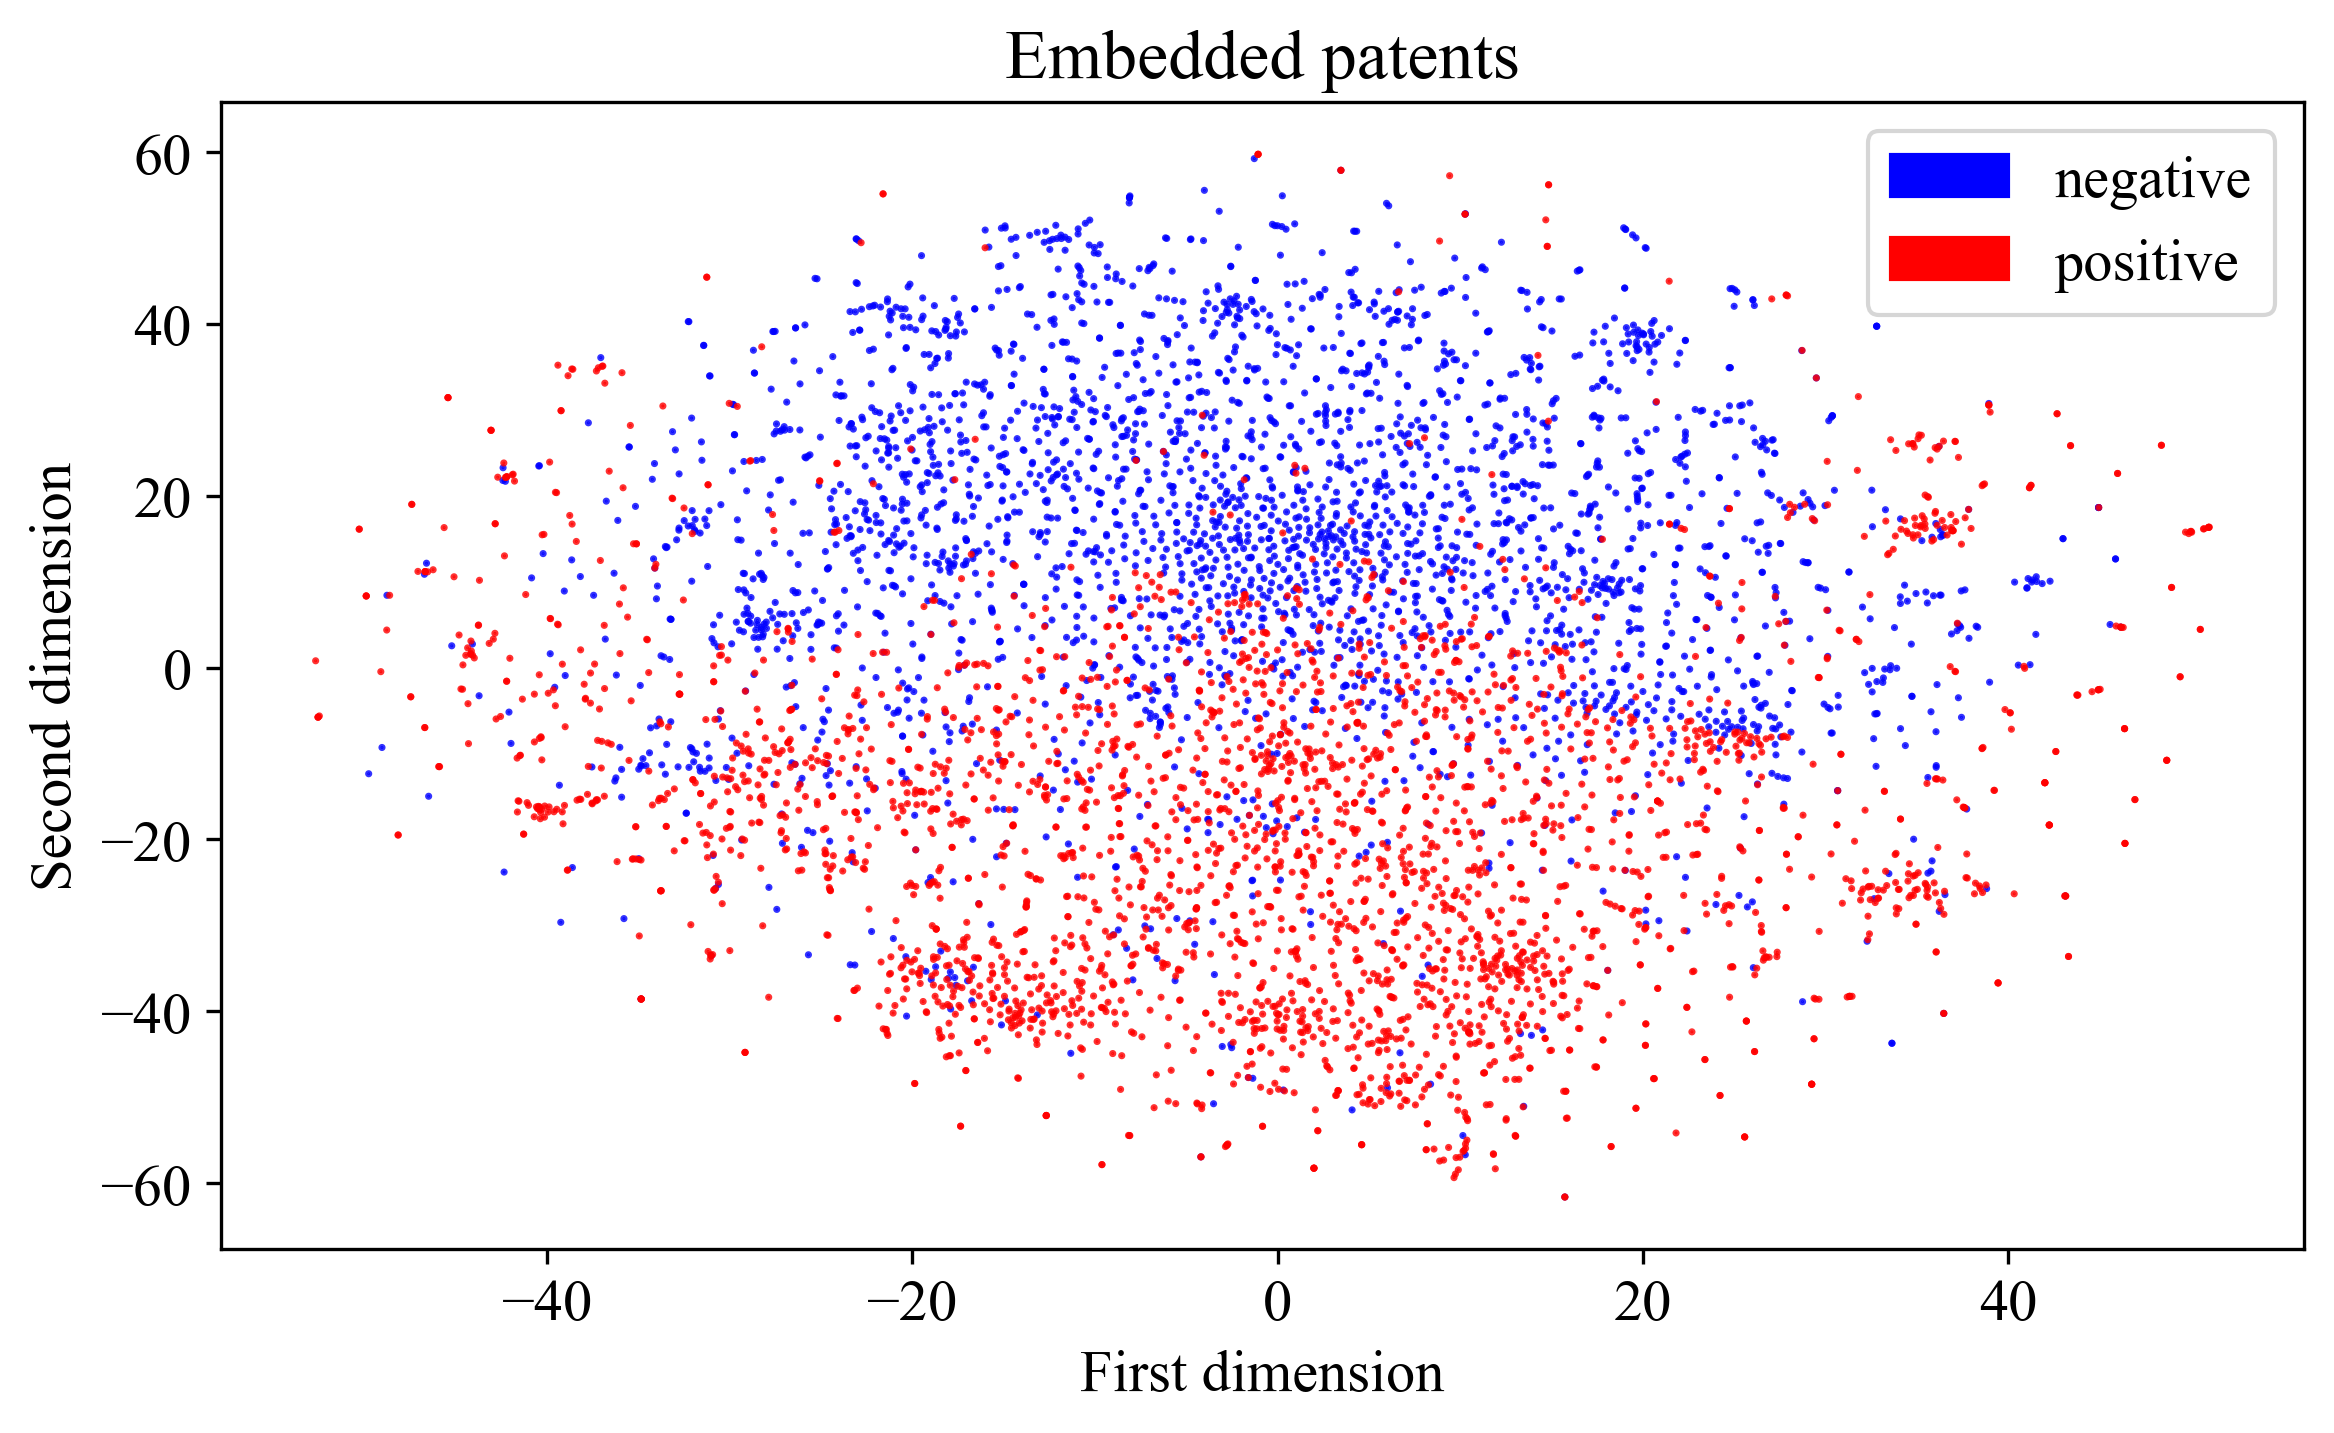

In [586]:
#'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 
# 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 
# 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 
# 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 
# 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 
# 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 
# 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 
# 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 
# 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 
# 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary',
#  'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 
# 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 
# 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r',
#  'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r',
#  'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2',
#  'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno',
#  'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 
# 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 
# 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer',
#  'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c',
#  'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 
# 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
plot_tsne(X_embedded, text_corpus.labels, cmap='bwr', labels=text_corpus.label_codes)

In [562]:
import umap
reducer = umap.UMAP()

In [563]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X.todense())
plot_tsne(embedding, text_corpus.labels, cmap='bwr', labels=text_corpus.label_codes)


F:\Anaconda\envs\enccs-nlp-workshop\lib\site-packages\sklearn\utils\validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



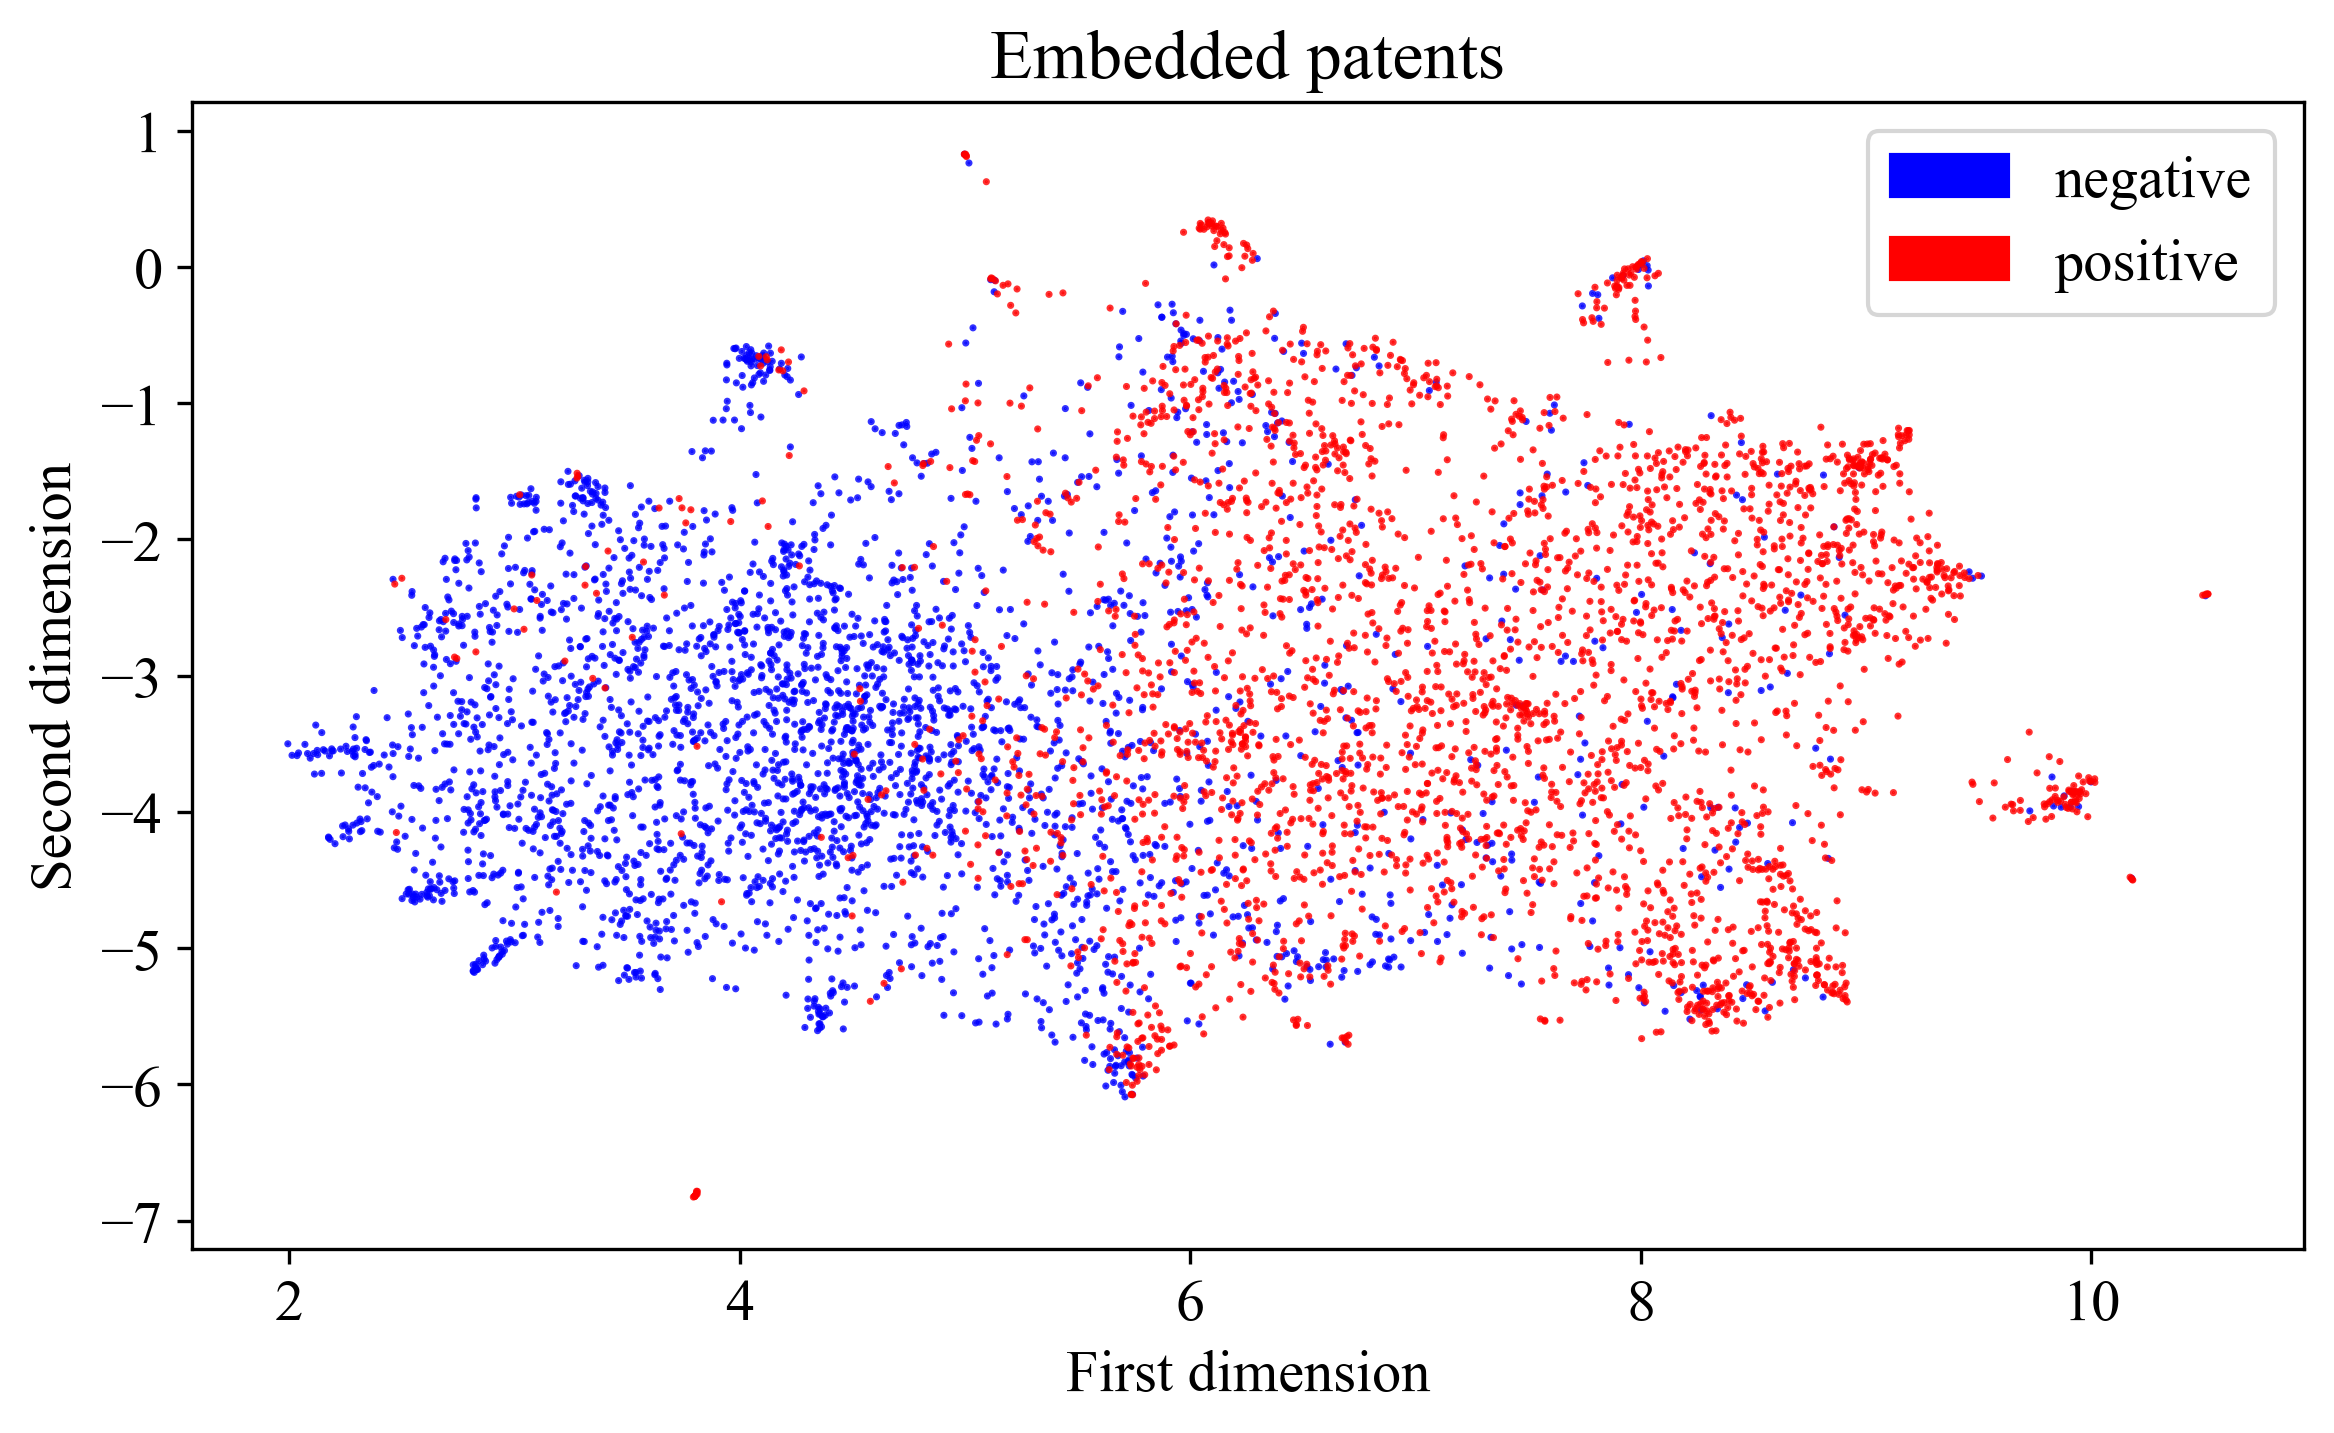

In [589]:
plot_tsne(embedding, text_corpus.labels, cmap='bwr', labels=text_corpus.label_codes)


In [730]:
import os
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from time import time
from pathlib import Path
import zipfile

import numpy as np
from scipy.sparse import hstack, vstack

from sklearn.manifold import TSNE
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm, trange

# Set plot properties
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({"font.size": 14})
# Cross-validate KNN classifier
def knn_classify(X, y, p=1, k=None, num_splits=5, metrics=None, ax=None):
    """ Evaluate the given embeddings of documents (rows of X) using K Nearest Neighbours 
        and cross validation.
        :param X: Matrix of document representations (along rows)
        :param y: vector of document labels as integer ids
        :param p: Parameter to use for the norm of the distance metric in K Nearest Neighbours. 1 is the manhattan distance, 2 is the Euclidean.
        :param k: Minimum number of neighbours to consider. Either an integer (only consider the given k) or an iterable of k's. Defaults to the range k in range(1, 11, 2)
        :param num_splits: Number of folds for cross validation
        :param metrics: List of metrics to calculate
        :return dictionary of metric name to dictionary of k neighbour values and CV results.
    """
    if metrics is None:
        metrics = ["precision", "recall", "f1"]#, "roc_auc", "average_precision"]
    if k is None:
        k = range(1, 13, 2)
    if isinstance(k, int):
        k = [k]
    else:
        k = list(k)
    collected_metrics = {metric_name: defaultdict(list) for metric_name in metrics}
    for k_ in tqdm(k):
        classifier = KNeighborsClassifier(n_neighbors=k_, p=p)
        # Scores for binary targets where positive examples are assumed to have label 1
        scores = cross_validate(classifier, X, y, cv=num_splits, scoring=metrics)
        for metric_name in metrics:
            collected_metrics[metric_name][k_].extend(scores["test_" + metric_name])
        #print(int(k/k_range[-1]*100)*'|', end='\r')

    if ax is None:
        ax = plt.gca()

    for metric_name, ranged_values in collected_metrics.items():
        k_range, values = zip(*sorted(ranged_values.items()))
        means = np.mean(values, axis=1)
        stds = np.std(values, axis=1)
        ci = 1.96 * stds/np.sqrt([len(v) for v in values])
        plot = ax.plot(k_range, means, label=metric_name)
        plot_color = plot[-1].get_color()
        ax.fill_between(k_range, (means-ci), (means+ci), color=plot_color, alpha=.1)
        
    ax.set_xlabel("k")
    ax.set_ylabel("Score")
    ax.set_xticks(k)
    ax.legend()
    ax.set_title(f"KNN results for different number of neighbours using the Minkowski p: {p}\nShaded region shows 95% CI")
    #plt.tight_layout()
    #plt.show()

In [731]:
range(2)

range(0, 2)

In [732]:
np.sqrt([1, 2, 3])

array([1.        , 1.41421356, 1.73205081])

100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


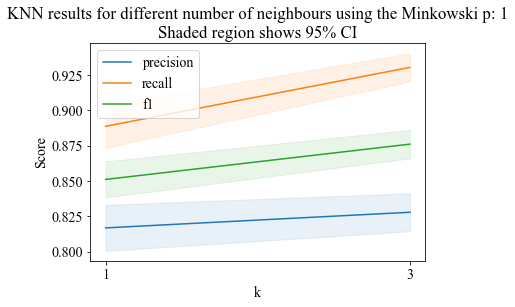

In [733]:
k = 1
fig, [ax1, ax2] = plt_subplots(1,2, sharex='row')
metrics = knn_classify(X, text_corpus.labels, k=k)
#plot_scores(metrics, with_labels=True)

100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


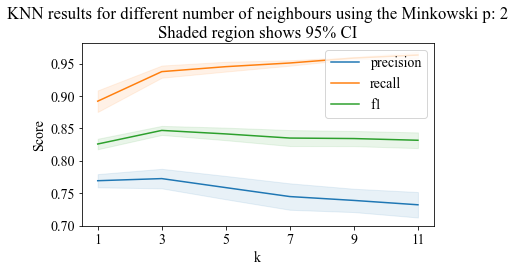

In [723]:
knn_classify(X, text_corpus.labels, p=2)

100%|██████████| 6/6 [00:21<00:00,  3.58s/it]


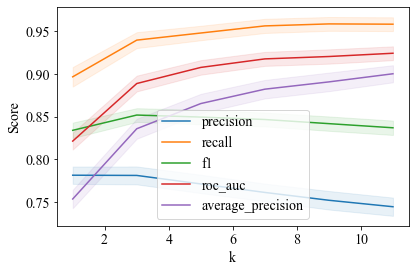

In [681]:
metrics = knn_classify(X, text_corpus.labels, num_splits=100)
plot_scores(metrics)

### Term Frequency - Inverse Document Frequency

While this bag-of-words representation works quite ok, theres a common problem with it. We removed some words which we though were not important, but we still have a distribution where the frequencies for less common words are far less than that for common. This means that documents which might have similar distributions of the uncommon (and often more meaningful) terms but might differ in the more common words will likely end up being viewed as dissimilar. A solution to this is to weight the terms differently, so that very common words contributes less to the distance between documents, while less common words contribute more. The rows of our document-term matrix is currently the **Term Frequencies**, each entry along the row correspond to the ratio of that term in the document. We would like to reweight these terms so that the common ones get lower scores and the uncommon ones get's higher.

We can do this in many ways, but one a common strategy is to multiply each term frequency with a value derived from how common words are:

$$\log \frac{N}{n_t}$$

Where $N$ is the total number of documents and $n_t$ is the number of documents the word occurs in. This value is referred to as the **Inverse Document Frequency**

You can see that for very common words which occur in all documents, this will be $log 1 = 0$ while for uncommon words this term will increase logarithmically with the fraction of documents they are not in. While we shouldn't have any terms which have 0 counts (i.e. in our case we don't include any terms which are not part of the corpus), in some situations you might use a predefined vocabulary. It's therefore common to use a smoothed version for this term which also penalize common words less harshly:

$$ \log (\frac{N}{1+n_t}) + 1 $$

This does not have the issue of potentially taking the logarithm of $0$, and does not scale down common words as drastically.


We'll compute these terms by first computing the $n_t$ term. One simple way of doing this is to use the `nonzero()` method. It returns two arrays which gives us the rows and columns of nonzero entries. If we count the number of times each column value appear in the result, we get the count of how many documents it occurs in (how many documents its frequency is not 0).

In [590]:
nonzero_row_idx, nonzero_col_idx = X.nonzero()

In [591]:
term_indicies, term_document_occurances = np.unique(nonzero_col_idx, return_counts=True)

In [592]:
term_document_occurances.max()

2493

In [593]:
idf = np.log( X.shape[0]/(1 + term_document_occurances)) + 1

In [594]:
idf

array([8.60090246, 8.31322039, 6.99146455, ..., 6.65499231, 8.31322039,
       6.92692603])

In [595]:
# In numpy we would just have broadcasted the word weights 
# over the array, but sparse arrays does not support this
# Instead we create a diagonal matrix consisting of the 
# values and multiply on the right, which will cause the 
# first column to be multiplied with the firts diagonal 
# entry, doing essentially the same thing as broadcasting
tf_idf = X @ scp.diags(idf, 0)

100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


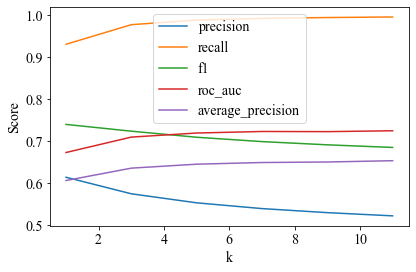

In [596]:
k_range, metrics = knn_classify(tf_idf, text_corpus.labels)
plot_scores(k_range, metrics, with_labels=True)

### Word vectors
In our current representation, words are treated as distinct symbols. While this kind of works (especially once we've tried to counter the statistical skew), our methods will not be able to make use of similarity between words. Synonymous words do not contribute to similarity between two documents.

A way to get around this is to instead represent each word as a vector in some vector space. In this representation, similar words could have similar vectors. We can think of the axises of this space to represent some kind of semantic about the word. E.g. `naturalness` or `colerfulness`.

We can think of our words as being a vector of *latent variables*, each variable correspond to some semantic of the word. The magnitude of this variable is then to what degree the semantics agree with that word. The figure below illustrates this idea:

![Word vectors](images/word_vectors.png)

It's important to point out that the _meaning_ of these axises is not something we design, but instead something which _emgerges_ through our model.

Similarily we could think of our documents as livining in the same latent semantical space, so each document is also a vector of the variables. We can then compare document vectors in this latent space instead of the Bag-of-words space. This allows our model to generalize to the underlying _meaning_ of words instead of treating them as symbols.

This basic idea permeates much of natural language processing. The fundamental question is how to construct the latent semantic vectors.

One of the simplest methods we can come up with is a linear model, where we say that the data we observe (our document-term matrix) is based on the linear combination (dot product) of the latent document vectors and the latent word vectors. In other words our model is the factorization of the document-term matrix:

$$A = UV^T, A \in \mathord{R}^{m \times n}, U \in \mathord{R}^{m \times k}, V \in \mathord{R}^{k \times n}$$

Where $m$ is the number of documents and $n$ the number of words. The dimensionality of the latent space, $k$, is a *hyper paremeter* we need to decide on. Traditionally in NLP this has been set to 300.

You can think of the matrices $U$ and $V$ as containing semantic vectors of the documents and terms along their columns, while the rows correspond to the different latent variables:

![Document vectors](images/document_vectors.png)

The task is now to identify the matrices $U$ and $V$ whose product best approximates $A$. One common choice is to minimize the squared difference between the elements, so minimize $(A_{i,j} - \langle \mathbf{u_i}, \mathbf{v_j} \rangle )^2$, which using the Frobenius norm can be written as:

$$ \underset{U,V}{\text{minimize}} \lVert A - U^TV \rVert_\mathcal{F}$$

It turns out that the _Singular Value Decomposition_ (SVD) of $A$, where we keep only the top $k$ singular values and their corresponding vectors is the solution to this problem.

The SVD is a way to decompose any matrix into three matrices:

$$A = U \Sigma V^T$$ 

In SVD $U \in \mathcal{R}^{m \times m}$ and $V \in \mathcal{R}^{n \times n}$ are orthogonal matrices, while $\Sigma \in \mathcal{R}^{m \times n}$ is a diagonal matrix, where the entries along the diagonal are the _singular values_.

If we truncate these matrices so that $\Sigma_k \in \mathcal{R}^{k \times k}$ is the square diagonal matrix we get by only keeping the top $k$ singular values, and
$U_k \in \mathcal{R}^{n \times k}$ and $V_k \in \mathcal{R}^{n \times k}$ are constructed from $U$ and $V$ by retaining only the singular vectors (along their columns) corresponding to the top $k$ singular values.





In [597]:
from scipy.sparse.linalg import svds
k = 200

u, s, vh = svds(tf_idf, k=k)

100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


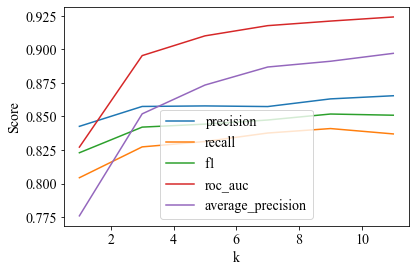

In [603]:
k_range, metrics = knn_classify(u[:,100:], text_corpus.labels)
plot_scores(k_range, metrics, with_labels=True)

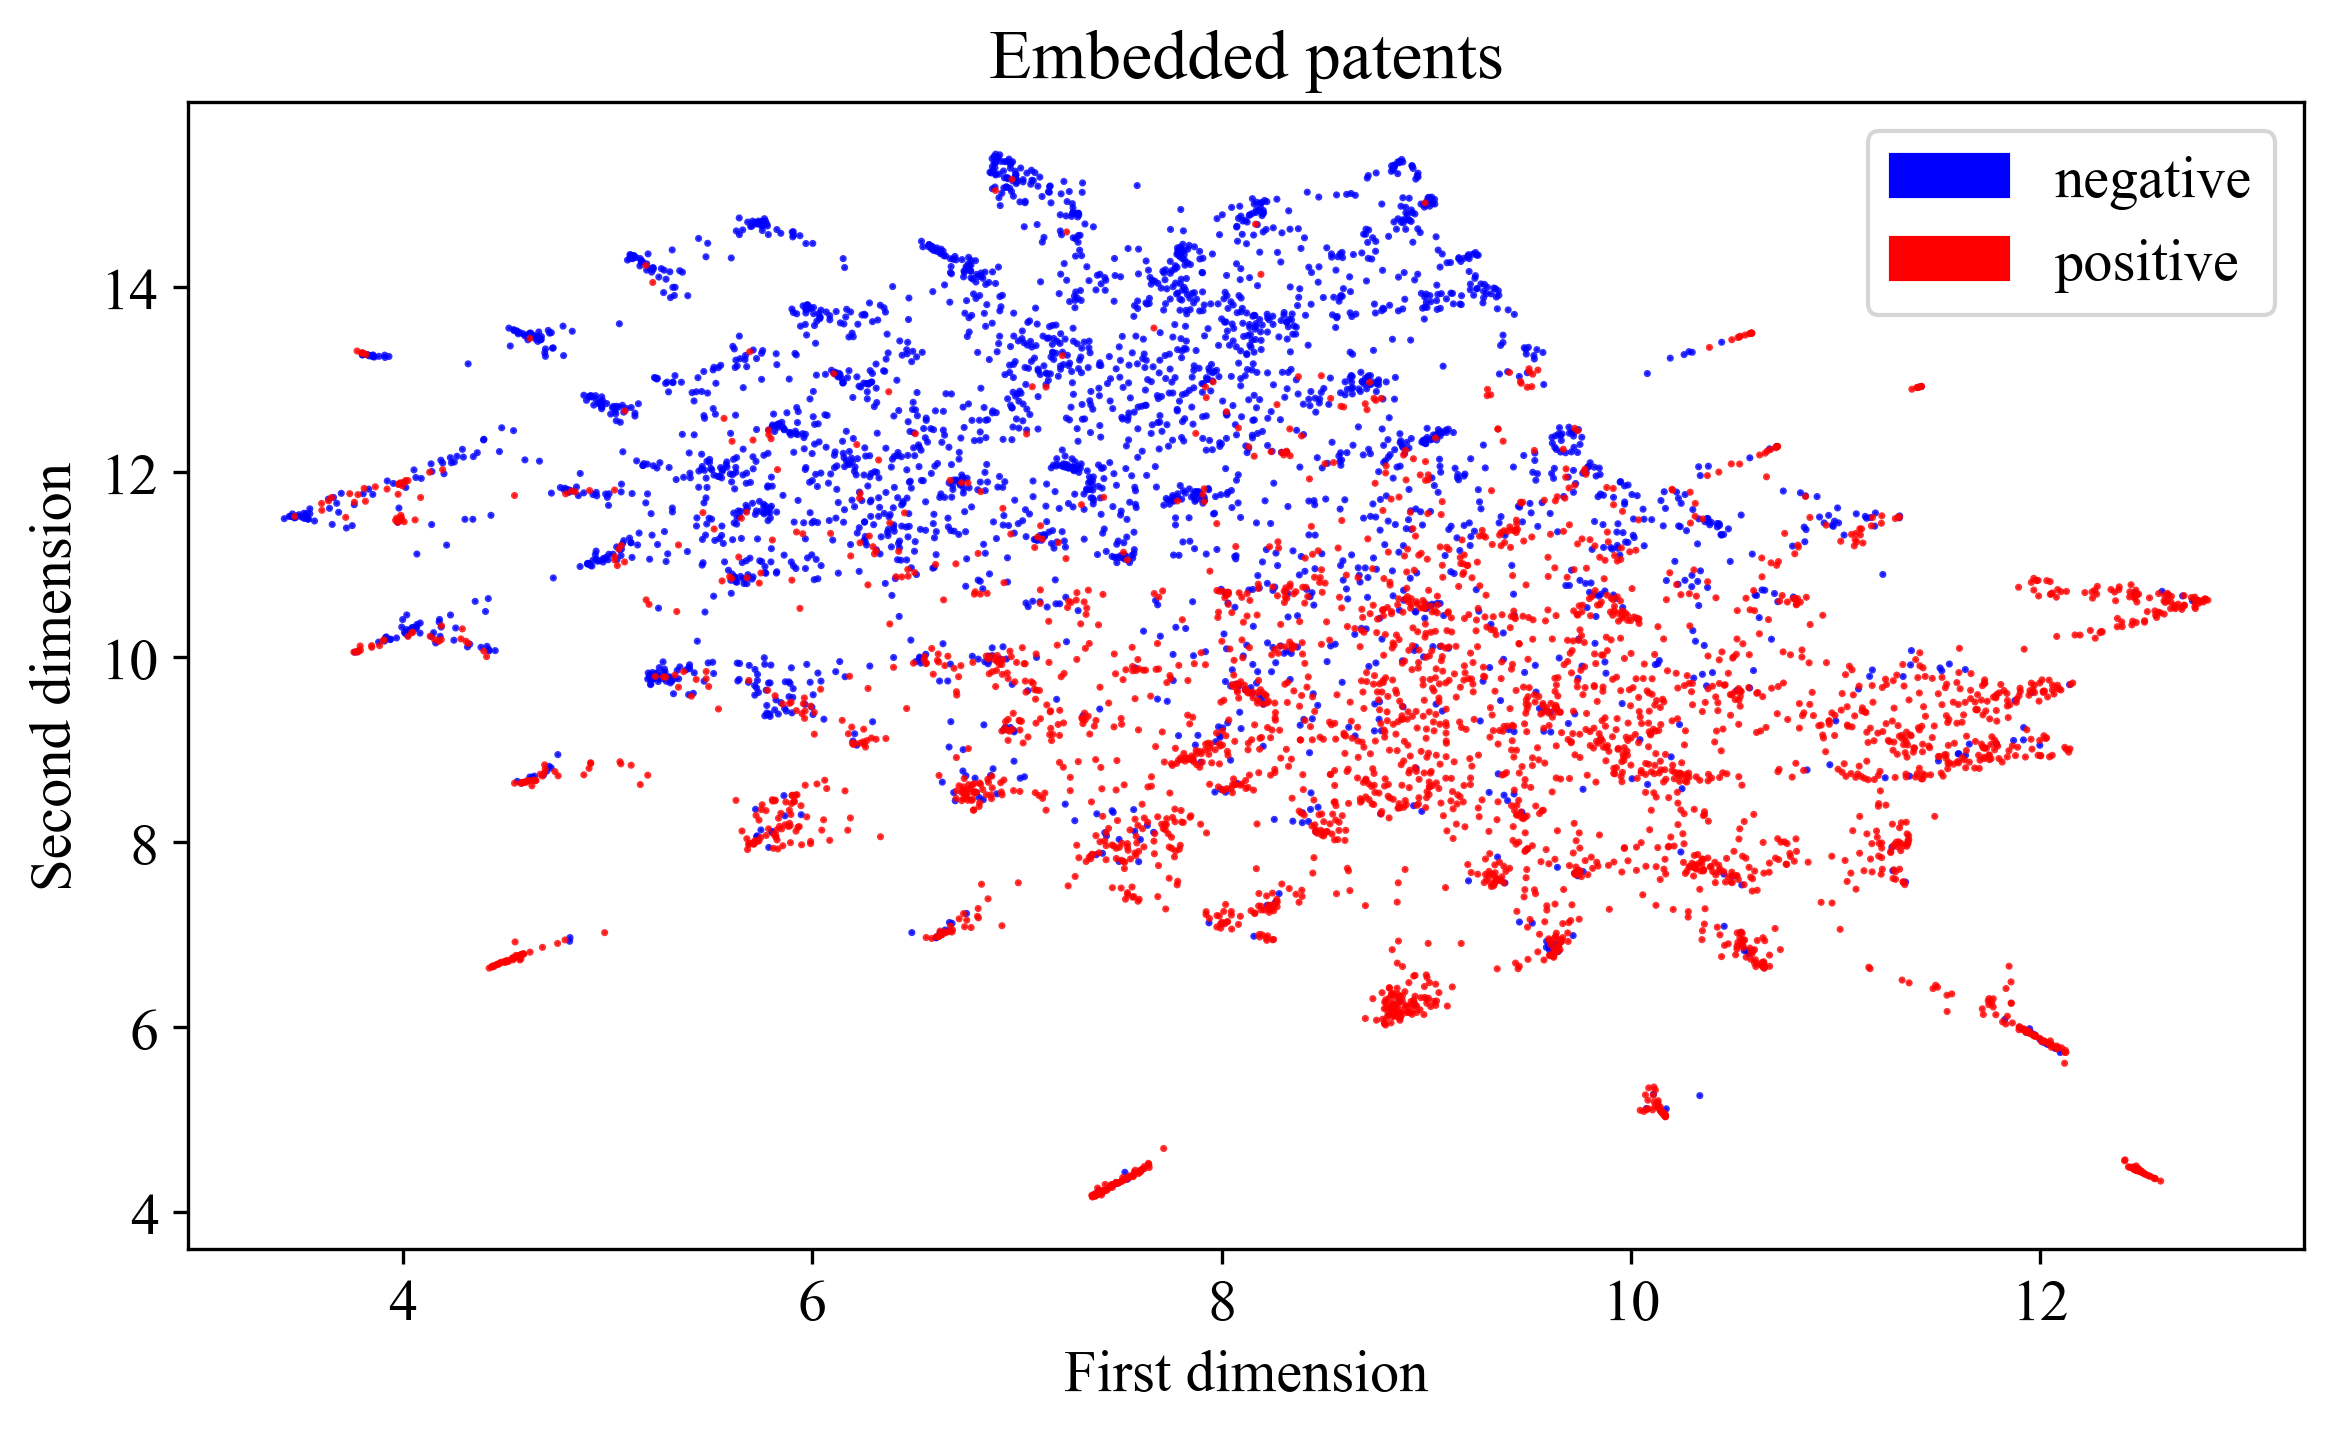

In [604]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(u[:,100:])
plot_tsne(embedding, text_corpus.labels, cmap='bwr', labels=text_corpus.label_codes)

### Non-negative matrix factorization

While the SVD has been proven to work well for creating these kind of document representations, the vectors it produce are dense. If we think of directions in the latent space as corresponding to some semantic property, we currently have the case that these properties can take both positive and negative values. We might instead wish for these properties to either be positive or zero. One constraint we can put on our matrices in the factorization is that they should all consist of non-negative values. The document-term matrix already is non-negative, so the challange is to find a factorization where $Q$ and $V$ are also non-negative. An interesting property now is that to produce a value $A_{i,j} = 0 \Rightarrow \langle \mathbf{q}_i, \mathbf{v}_j \rangle = 0$, so to produce $0$ values in the document-term matrix, the correponding document and row vectors has to be orthogonal. We will still use the same loss function, the Frobenius norm of the difference between the low rank approximation and the observed matrix.

In [499]:
from sklearn.decomposition import NMF
model = NMF(n_components=k)
W = model.fit_transform(X)
H = model.components_



F:\Anaconda\envs\enccs-nlp-workshop\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


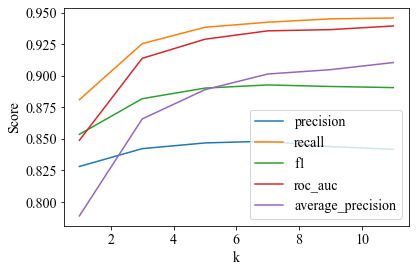

In [502]:
k_range, metrics = knn_classify(W, text_corpus.labels)
plot_scores(k_range, metrics, with_labels=True)

This notion of rows of the document and term matrices to correspond to semantic variables is essentially the same as saying that the canonical basis vectors are the directions corresponding to the semantics. While this helps to get an intuition of how to think about these semantic vectors, it is actually not true. Recall that the dot product between two vectors is preserved under an orthogonal transformation (e.g. rotation)), i.e. if we multiply both $U$ and $V$ with an orthogonal matrix $Q \in \mathord{R}^{k \times k}$ we have:

$$(QU)^T QV = U^TQ^TQ V = U^T I V = U^T V$$

In other words, the directions in the $k$-dimensional space which correspond to semantics can have any direction so it is not actually the rows of $U$ and $V$ which correspond to the latent variables.

For a more indepth discussion on dimensionality see:

   "Karlgren, Jussi, Anders Holst, and Magnus Sahlgren. "Filaments of meaning in word space." European Conference on Information Retrieval. Springer, Berlin, Heidelberg, 2008."


In [619]:
from sklearn import utils
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import multiprocessing
cores = multiprocessing.cpu_count()



In [631]:
train_tagged = [TaggedDocument(words=tokenizer.tokenize(text), tags=[label]) for text, label in zip(text_corpus, text_corpus.labels)]

In [632]:
train_tagged[0]

TaggedDocument(words=['the', 'invention', 'relates', 'to', 'a', 'method', 'for', 'removing', 'labels', 'from', 'containers', 'used', 'in', 'the', 'production', 'storage', 'transport', 'and', 'or', 'distribution', 'of', 'food', 'products', 'or', 'pharmaceutical', 'products', 'which', 'is', 'characterized', 'in', 'that', 'solid', 'co2', 'particles', 'especially', 'co2', 'pellets', 'or', 'co2', 'snow', 'particles', 'are', 'blasted', 'onto', 'said', 'containers', 'figure'], tags=[0])

In [633]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged)])

100%|██████████| 6000/6000 [00:00<00:00, 3001290.88it/s]


In [648]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged)]), total_examples=len(train_tagged), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 6000/6000 [00:00<00:00, 3002365.07it/s]


Wall time: 8.34 s


In [635]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model_dbow.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [649]:
targets, regressors = zip(*[(doc.tags[0], model_dbow.infer_vector(doc.words)) for doc in train_tagged])

In [650]:
dbow_docs = np.stack(regressors, axis=0)

In [645]:
dbow_docs.shape

(6000, 300)

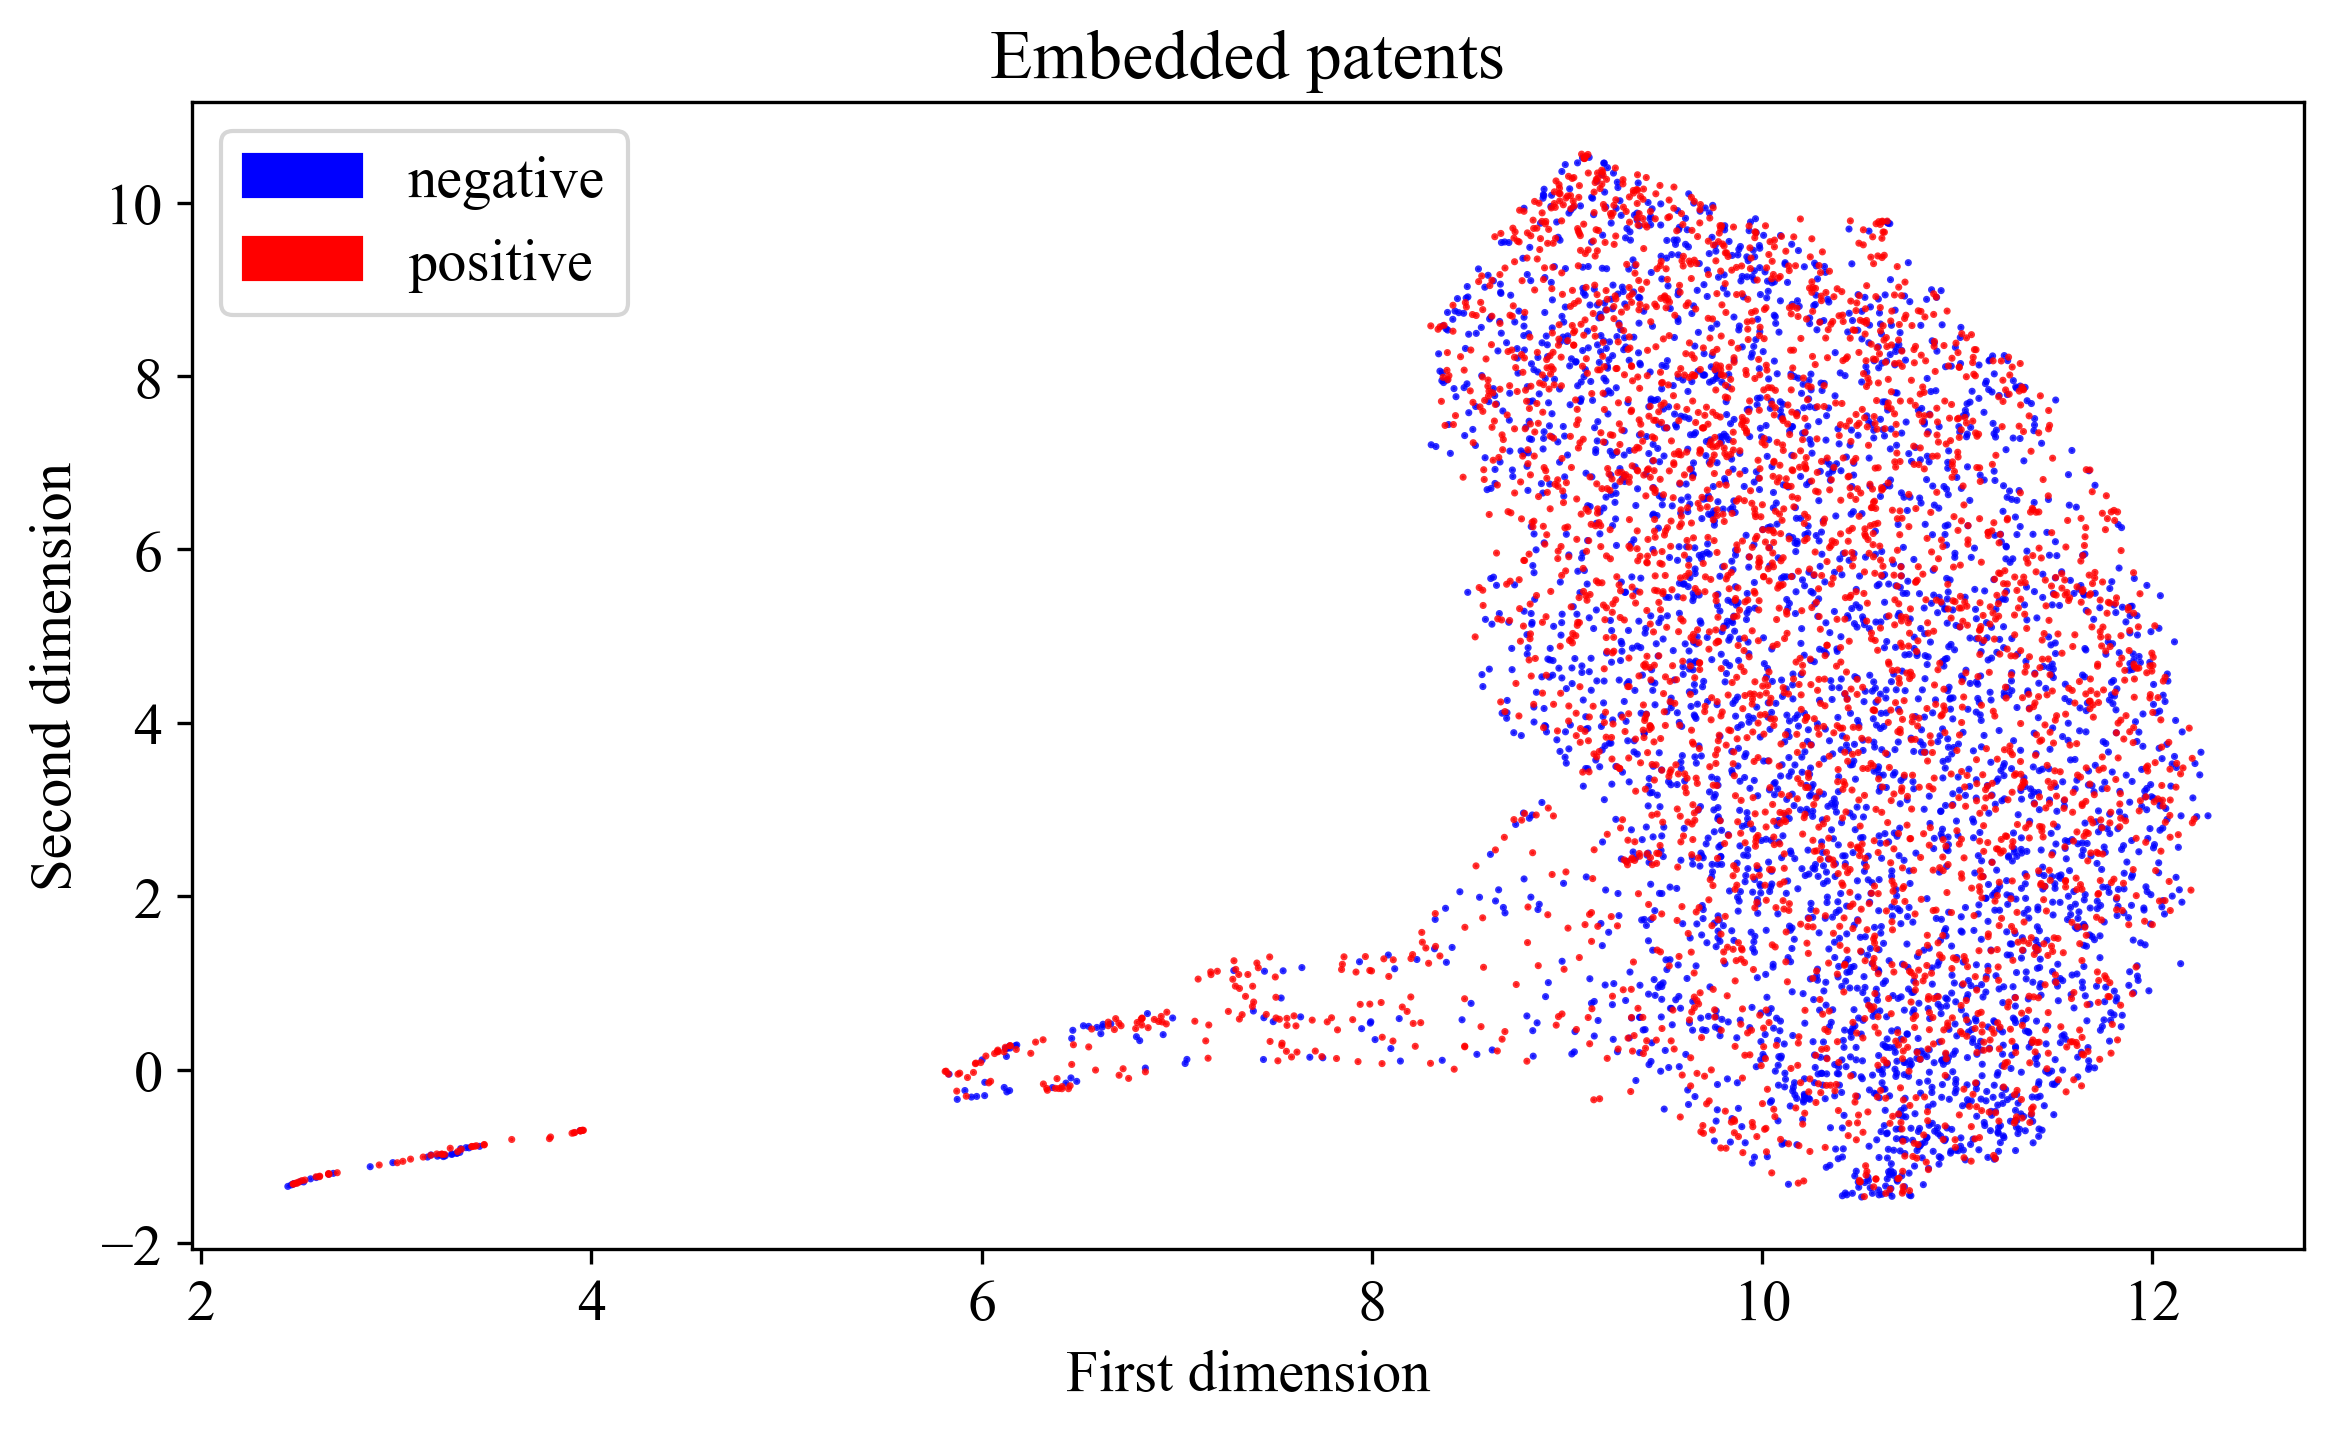

In [651]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(dbow_docs)
plot_tsne(embedding, text_corpus.labels, cmap='bwr', labels=text_corpus.label_codes)

100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


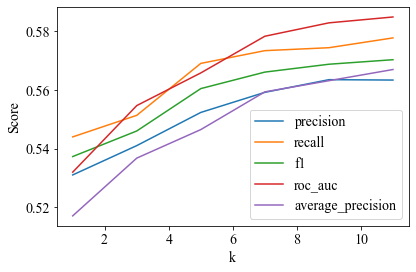

In [647]:
k_range, metrics = knn_classify(dbow_docs, text_corpus.labels)
plot_scores(k_range, metrics, with_labels=True)